# **Elementary studies on single axisyymetric element**

First study of Euro-C Paper

In [1]:
%matplotlib widget
import numpy as np
np.seterr(divide='ignore', invalid='ignore') 
import matplotlib.pylab as plt
from ibvpy.bcond import BCSlice, BCDof
from ibvpy.fets import FETS3D8H
from ibvpy.fets import FETS2D4Q
from ibvpy.tmodel.mats3D import MATS3DElastic
import bmcs_matmod.ms1.concrete_material_db as mp_db
from ibvpy.tmodel.viz3d_scalar_field import \
    Vis3DStateField, Viz3DScalarField
from ibvpy.tmodel.viz3d_tensor_field import \
    Vis3DTensorField, Viz3DTensorField
from ibvpy.sim.tstep_bc import TStepBC
from ibvpy.xmodel.xdomain_fe_grid import XDomainFEGrid
from ibvpy.xmodel.xdomain_fe_grid_axisym import XDomainFEGridAxiSym
from ibvpy.api import TStepBC, TFCyclicNonsymmetricConstant, TFBilinear
from mayavi import mlab
from bmcs_matmod.ms1 import MS13D
from bmcs_matmod.ms1 import MS13D_damage_jir
from ibvpy.tmodel.mats3D.mats3D_microplane.vmats3D_mpl_d_eeq import \
    MATS3DMplDamageEEQ
from ibvpy.bcond import BCSliceI, BCDof
from ibvpy.tfunction import TimeFunction, TFSelector, TFCyclicSin, TFCyclicNonsymmetricConstant
import copy
import matplotlib as mpl
import string

In [2]:
def get_damage(m):   
    radial_damage = []
    hoop_damage = []
    shear_damage = []

    for i in range(len(m.hist.state_vars)):
        omega_T_Emn = np.average(m.hist.state_vars[i][0]['omega_T_Emn'],axis=1)
        omega_N_Emn = np.average(m.hist.state_vars[i][0]['omega_N_Emn'],axis=1)
        beta_N = 1. - omega_N_Emn
        beta_T = 1. - omega_T_Emn
        delta = m_inelastic.DELTA

        beta_ijkl = np.einsum('n, ...n,ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_N, m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN,
                              m_inelastic._MPN) + \
                    0.25 * (np.einsum('n, ...n,ni, nk, jl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,ni, nl, jk -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,nj, nk, il -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,nj, nl, ik -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) -
                            4.0 * np.einsum('n, ...n, ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN,
                                            m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN))

        radial_damage.append(1-(beta_ijkl)[0,1,1,1,1]**2)
        hoop_damage.append(1-(beta_ijkl)[0,2,2,2,2]**2)
        shear_damage.append(1-((beta_ijkl)[0,1,0,1,0]*2)**2)
    return radial_damage, hoop_damage, shear_damage

In [3]:
def get_omega_N(m):
    omega_N_11 = np.zeros((len(m.hist.state_vars),8))
    for i in range(len(m.hist.state_vars)):
        omega_N_11[i] = np.array([ m.hist.state_vars[i][0]['omega_N_Emn'][0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        
    omega_N_01 = np.zeros((len(m.hist.state_vars),8))
    for i in range(len(m.hist.state_vars)):
        omega_N_01[i] = np.array([ m.hist.state_vars[i][0]['omega_N_Emn'][0,0][j] for j in [0,1,4,5,20,21,24,25]])
    return omega_N_01, omega_N_11    

In [4]:
def get_omega_T(m):
    omega_T_11 = np.zeros((len(m.hist.state_vars),8))
    for i in range(len(m.hist.state_vars)):
        omega_T_11[i] = np.array([ m.hist.state_vars[i][0]['omega_T_Emn'][0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        
    omega_T_01 = np.zeros((len(m.hist.state_vars),20))
    for i in range(len(m.hist.state_vars)):
        omega_T_01[i] = np.array([ m.hist.state_vars[i][0]['omega_T_Emn'][0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
        
    return omega_T_01, omega_T_11    

In [5]:
CAxisymm = dict(
    E = 30e+3,
    nu = 0.18,
    Ad = 5000.0,
    eps_0 = 0.0001,
    K_N = 0.,
    sigma_N_0 = 1000.,
    gamma_N = 2000.,
    sigma_T_0 = 5,
    K_T = 0.0,
    gamma_T = 2000.,
    S_T = 0.001,
    c_T = 2.0,
    r_T = 3.0,
    m_T = 0.1,
    p_T = 1.
)

## Unit element Axisymm - monotonic

In [6]:
n_x_e = 3
n_inner_y_e = 1
n_outer_y_e = 1
L_x = 90.0 # [mm]
d_x = L_x / n_x_e
R_in = 25 # [mm]
dR = 2 # [mm]
R_out = 50 # [mm]
len_notch = 30
n_notch = 1

xmodel = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                               coord_min=(0+n_notch*d_x, R_in),
                               coord_max=(L_x-n_notch*d_x, R_in+dR),
                               shape=(n_x_e-2*n_notch, 1),
                               fets=FETS2D4Q())

m_inelastic = MS13D(**CAxisymm)
m_elastic = MATS3DElastic(E=40000, nu=0.18)
m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [7]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=0.2)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=0.2)

In [8]:
slide_upper_slice = BCSliceI(slice=xmodel.mesh.I[:, -1],
                                   var='u', dims=[0], value=0.0)
slide_upper_dofs = slide_upper_slice.dofs

slide_lower_slice = BCSliceI(slice=xmodel.mesh.I[:, 0],
                                   var='u', dims=[0], value=0.0)
slide_lower_dofs = slide_lower_slice.dofs

confinement_upper_slice = BCSliceI(slice=xmodel.mesh.I[:, -1],
                                   var='u', dims=[1], value=0.0)
confinement_upper_dofs = confinement_upper_slice.dofs

confinement_lower_slice = BCSliceI(slice=xmodel.mesh.I[:, 0],
                                   var='u', dims=[1], value=0.0)
confinement_lower_dofs = confinement_lower_slice.dofs


In [9]:
m_list_monotnonic = []
compression_level = np.array([5,0,-10])

w_max = 0.03

for compression in compression_level:
    m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
    )
    # Shear bc
    slide = 0.05
    compression_stress = compression

    inner_fixed_0 = slide_lower_slice
    inner_fixed_1 = confinement_lower_slice

    compression_force = compression_stress * 2 * np.pi * (R_in+dR) * len_notch / len(confinement_upper_dofs)
    upper_compression_force = [BCDof(var='f', dof=dof, value=compression_force, 
                                     time_function=tf_precrompression)
                               for dof in confinement_upper_dofs]
    # upper_compression_force[0].value *= 0.5
    # upper_compression_force[-1].value *= 0.5

    slide_upper = [BCDof(var='u', dof=dof, value=slide, time_function=tf_sliding)
                         for dof in slide_upper_dofs]
    bc1 = [inner_fixed_0, inner_fixed_1] + slide_upper + upper_compression_force

    m.bc=bc1
    m.hist.vis_record = {
    #    'strain': Vis3DTensorField(var='eps_ab'),
        'stress': Vis3DTensorField(var='sig_ab'),
        #        'kinematic hardening': Vis3DStateField(var='z_a')
    }

    s = m.sim
    s.tloop.verbose = False
    s.tloop.k_max = 1000
    s.tline.step = 0.005
    # Accessing the following property - ensures serialization
    s.tstep.fe_domain.serialized_subdomains
    s.reset()
    try:
        s.run()
    except:
        # m_list_monotnonic.append(m)
        pass
    m_list_monotnonic.append(m)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
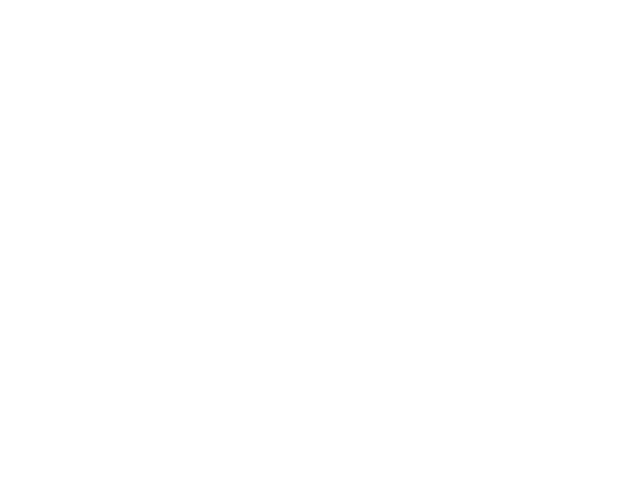

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
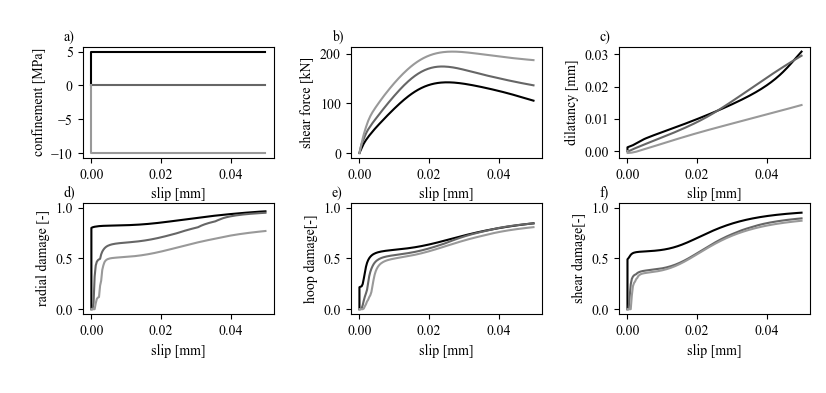

In [10]:
cm = 1/2.54  # centimeters in inches
plt.style.use('grayscale')

plt.tight_layout()
max_F = []
plt.rcParams["font.family"] = "Times New Roman"




fig, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(2, 3,figsize=(21*cm, 10*cm))



for m,compression in zip(m_list_monotnonic,compression_level):
    U_slide = np.average(m.hist.U_t[:, slide_upper_dofs], axis=-1)
    U_dilatancy  =m.hist.U_t[:, confinement_upper_dofs[0]]
    F_slide = np.sum(m.hist.F_t[:, slide_upper_dofs], axis=-1)
    radial_damage, hoop_damage, shear_damage = get_damage(m)

    F_confinement = np.sum(m.hist.F_t[:, confinement_upper_dofs], axis=-1)
    max_F.append(max(abs(F_slide)))
    
    ax1.plot(U_slide, F_confinement/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x)), label=str(compression))
    ax1.set_ylabel('confinement [MPa]', fontsize=10)
    ax1.set_xlabel('slip [mm]', fontsize=10)
    
    ax2.plot(U_slide, F_slide/1000, label=str(compression))
    ax2.set_ylabel('shear force [kN]', fontsize=10)
    ax2.set_xlabel('slip [mm]', fontsize=10)
    
    ax3.plot(U_slide, U_dilatancy, label=str(compression))
    ax3.set_ylabel('dilatancy [mm]', fontsize=10)
    ax3.set_xlabel('slip [mm]', fontsize=10)
    
    
    # ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
    ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
    ax4.set_ylabel('radial damage [-]', fontsize=10)
    ax4.set_xlabel('slip [mm]', fontsize=10)
    ax4.set_ylim(-0.05,1.05)
    
    ax5.plot(U_slide, hoop_damage, label='hoop damage'+str(compression))
    ax5.set_ylabel('hoop damage[-]', fontsize=10)
    ax5.set_xlabel('slip [mm]', fontsize=10)
    ax5.set_ylim(-0.05,1.05)
    
    # ax6.plot(F_slide/1000, shear_damage, label='shear damage'+str(compression))
    ax6.plot(U_slide, shear_damage, label='shear damage'+str(compression))
    ax6.set_ylabel('shear damage[-]', fontsize=10)
    ax6.set_xlabel('slip [mm]', fontsize=10)
    ax6.set_ylim(-0.05,1.05)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)
for n, ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6]):     
    ax.text(-0.1, 1.05, string.ascii_lowercase[n] + ')', transform=ax.transAxes, 
            size=10)  

# txt=str(CAxisymm)
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)

# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\pdf\\study01_monotonic_' + str(simmulation_number) + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\png\\study01_monotonic_' + str(simmulation_number) + '.png')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
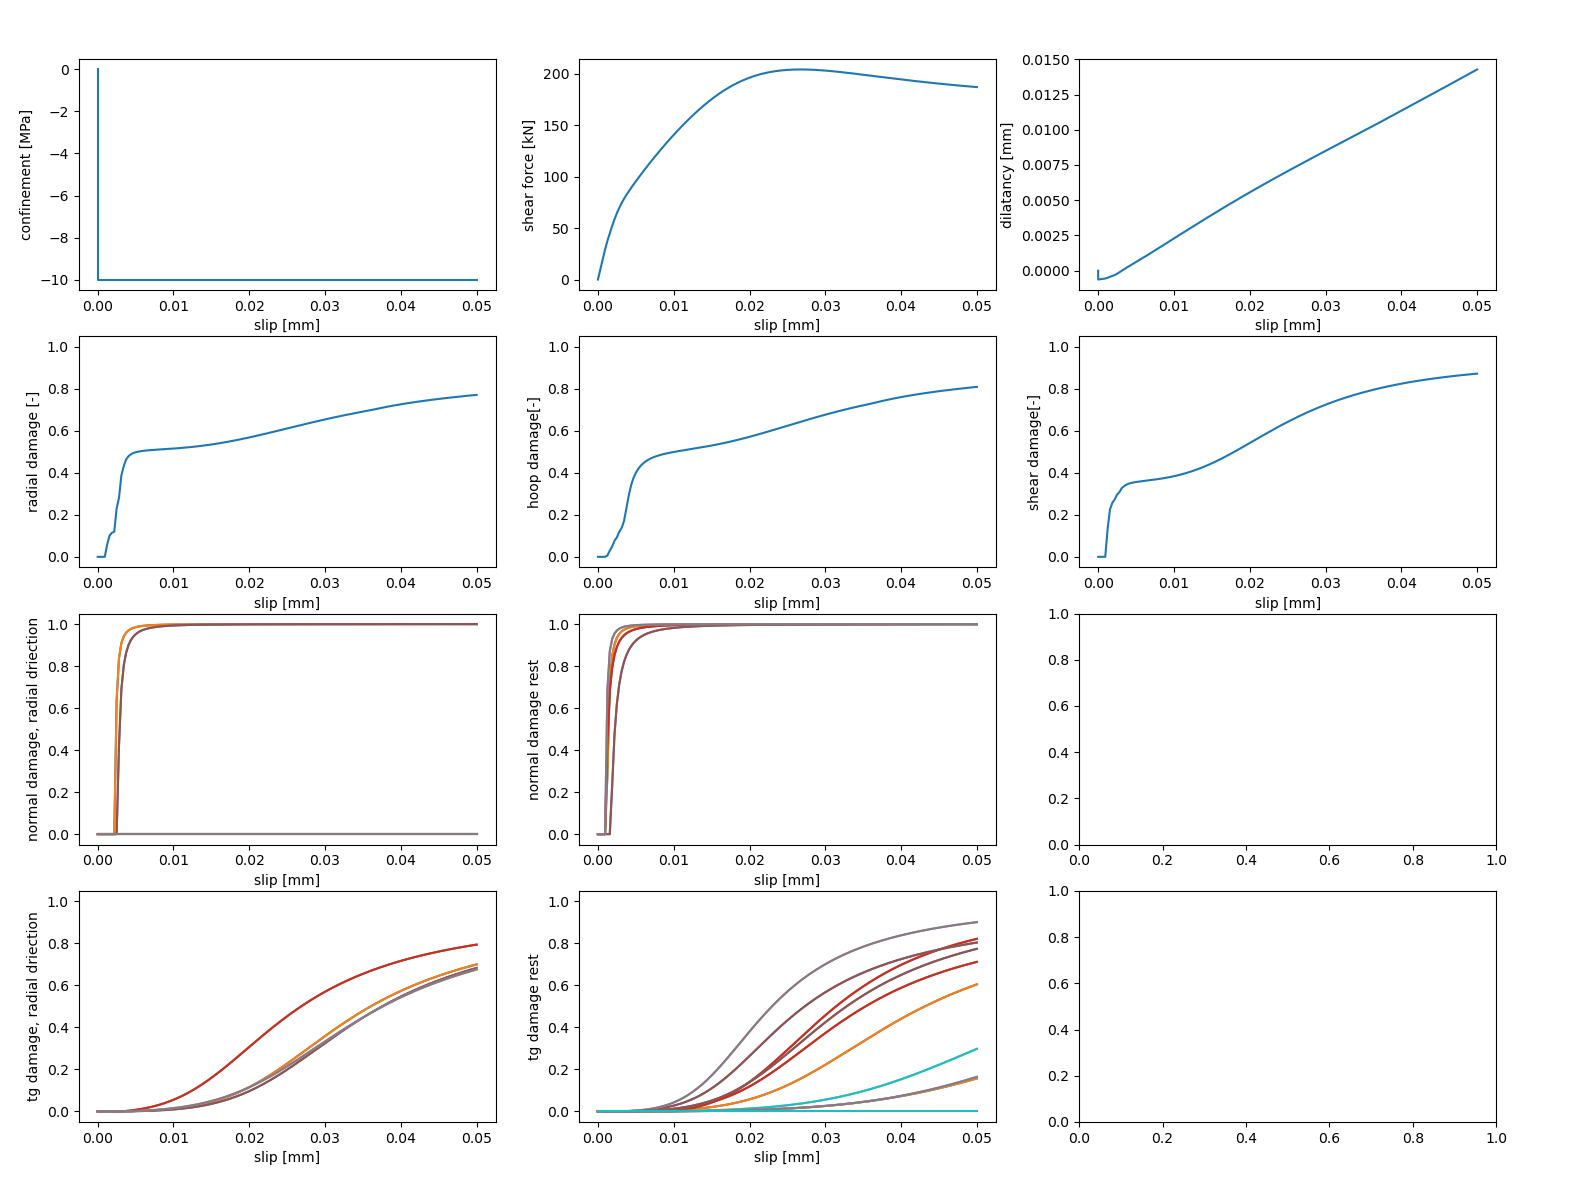

In [11]:
plt.style.use('default')

# plt.tight_layout()

cm = 1/2.54  # centimeters in inches
fig, ((ax1,ax2,ax3), (ax4,ax5,ax6), (ax7,ax8,ax9), (ax10,ax11,ax12)) = plt.subplots(4, 3,figsize=(40*cm, 30*cm))

# txt=str(CAxisymm)


idx = 2
m = m_list_monotnonic[idx]
compression = compression_level[idx]
# plt.rcParams["font.family"] = "Times New Roman"
 
    
U_slide = np.average(m.hist.U_t[:, slide_upper_dofs], axis=-1)
U_dilatancy  =m.hist.U_t[:, confinement_upper_dofs[0]]
F_slide = np.sum(m.hist.F_t[:, slide_upper_dofs], axis=-1)
radial_damage, hoop_damage, shear_damage = get_damage(m)

F_confinement = np.sum(m.hist.F_t[:, confinement_upper_dofs], axis=-1)


ax1.plot(U_slide, F_confinement/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x)), label=str(compression))
ax1.set_ylabel('confinement [MPa]', fontsize=10)
ax1.set_xlabel('slip [mm]', fontsize=10)

ax2.plot(U_slide, F_slide/1000, label=str(compression))
ax2.set_ylabel('shear force [kN]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(U_slide, U_dilatancy, label=str(compression))
ax3.set_ylabel('dilatancy [mm]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)


# ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
ax4.set_ylabel('radial damage [-]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)
ax4.set_ylim(-0.05,1.05)

ax5.plot(U_slide, hoop_damage, label='hoop damage'+str(compression))
ax5.set_ylabel('hoop damage[-]', fontsize=10)
ax5.set_xlabel('slip [mm]', fontsize=10)
ax5.set_ylim(-0.05,1.05)

# ax6.plot(F_slide/1000, shear_damage, label='shear damage'+str(compression))
ax6.plot(U_slide, shear_damage, label='shear damage'+str(compression))
ax6.set_ylabel('shear damage[-]', fontsize=10)
ax6.set_xlabel('slip [mm]', fontsize=10)
ax6.set_ylim(-0.05,1.05)

omega_N_01, omega_N_11 = get_omega_N(m) 
ax7.plot(U_slide, omega_N_11)
ax7.set_ylabel('normal damage, radial driection', fontsize=10)
ax7.set_xlabel('slip [mm]', fontsize=10)
ax7.set_ylim(-0.05,1.05)


ax8.plot(U_slide, omega_N_01, label='shear damage'+str(compression))
ax8.set_ylabel('normal damage rest', fontsize=10)
ax8.set_xlabel('slip [mm]', fontsize=10)
ax8.set_ylim(-0.05,1.05)

omega_T_01, omega_T_11 = get_omega_T(m) 
ax10.plot(U_slide, omega_T_11)
ax10.set_ylabel('tg damage, radial driection', fontsize=10)
ax10.set_xlabel('slip [mm]', fontsize=10)
ax10.set_ylim(-0.05,1.05)


ax11.plot(U_slide, omega_T_01, label='shear damage'+str(compression))
ax11.set_ylabel('tg damage rest', fontsize=10)
ax11.set_xlabel('slip [mm]', fontsize=10)
ax11.set_ylim(-0.05,1.05)
    

left  = 0.05  # the left side of the subplots of the figure
right = 0.95  # the right side of the subplots of the figure
bottom = 0.05   # the bottom of the subplots of the figure
top = 0.95      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)


## Cyclic

In [12]:
number_of_cycles = 394
shift_cycles = 1
steps_branch = 50
tf_cyclic = TFCyclicNonsymmetricConstant(number_of_cycles=number_of_cycles, unloading_ratio=0.2, shift_cycles=shift_cycles)
tf_confinement = TFBilinear(loading_ratio=1, time_ratio=1/(number_of_cycles+shift_cycles))

In [13]:
m_list = []
compression_level = np.array([5,0,-10])

S_max = 0.80
w_max = 0.05

# for compression, slide in zip(compression_level, max_F):
for compression in compression_level:
# for compression in [compression_level[-1]]:


    
    m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
    )
    # Shear bc
        
    compression_stress = compression

    inner_fixed_0 = slide_lower_slice
    inner_fixed_1 = confinement_lower_slice
    
    compression_force = compression_stress * 2 * np.pi * (R_in + dR) * len_notch / (len(confinement_upper_dofs))
    upper_compression_force = [BCDof(var='f', dof=dof, value=compression_force, 
                                     time_function=tf_confinement)
                               for dof in confinement_upper_dofs]   
    # upper_compression_force[0].value *= 0.5
    # upper_compression_force[-1].value *= 0.5
    slide_force = 115000/ (len(slide_upper_dofs))

    slide_upper = [BCDof(var='f', dof=dof, value=slide_force, time_function=tf_cyclic)
                         for dof in slide_upper_dofs]
    # slide_upper[0].value *= 0.5
    # slide_upper[-1].value *= 0.5
    bc1 = [inner_fixed_0, inner_fixed_1] + slide_upper + upper_compression_force

    m.bc=bc1
    m.hist.vis_record = {
    #    'strain': Vis3DTensorField(var='eps_ab'),
        'stress': Vis3DTensorField(var='sig_ab'),
        #        'kinematic hardening': Vis3DStateField(var='z_a')
    }

    s = m.sim
    s.tloop.verbose = False
    s.tloop.k_max = 1000
    s.tloop.acc = 1e-1
    s.tline.step = 1/(steps_branch*2*(number_of_cycles+1))
    # Accessing the following property - ensures serialization
    s.tstep.fe_domain.serialized_subdomains
    s.reset()
    try:
        s.run()
    except:
        pass
    m_list.append(m)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
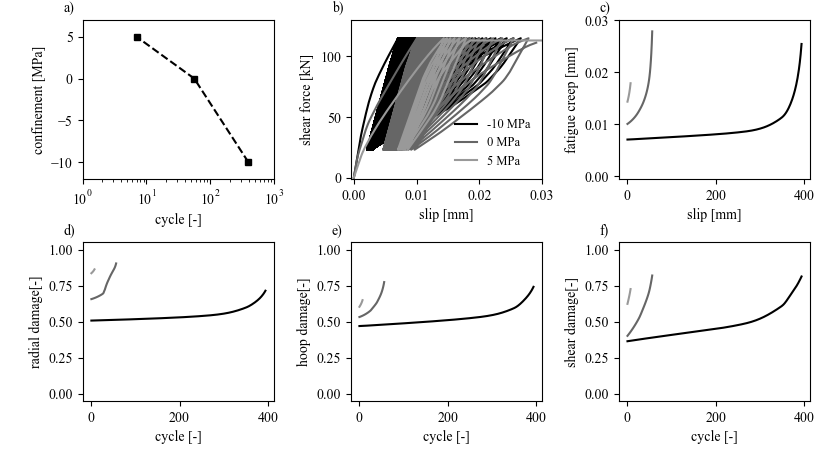

In [22]:
cm = 1/2.54  # centimeters in inches
plt.style.use('grayscale')

plt.tight_layout()
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(2, 3,figsize=(21*cm, 12*cm))
compression_level = np.array([5,0,-10])

start = int((shift_cycles+2)*steps_branch)
end = int(steps_branch)
plt.tight_layout()
N = []

for m,compression in zip(m_list[::-1],compression_level[::-1]):#
    # m = m_list[0]
    # compression = compression_level[0]
    U_slide = np.average(m.hist.U_t[:, slide_upper_dofs], axis=-1)
    cycles = np.linspace(0, len(U_slide[start::steps_branch*2]),len(U_slide[start:-steps_branch:steps_branch*2]))
    # print(U_slide[start::steps_branch].shape)
    radial_damage, hoop_damage, shear_damage = get_damage(m)
    U_dilatancy = np.average(m.hist.U_t[:, confinement_upper_dofs], axis=-1)
    F_slide = np.sum(m.hist.F_t[:, slide_upper_dofs], axis=-1)
    # print(F_slide.shape)
    # print(F_slide[start::steps_branch*2].shape)
    F_confinement = np.sum(m.hist.F_t[:, confinement_upper_dofs], axis=-1)
    # print(cycles)
    N.append(cycles[-1])
    # ax1.plot(cycles[-1], compression,  'bs')
    # ax1.plot(cycles, F_confinement[start:-steps_branch:steps_branch*2]/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x)), label=str(compression))
    # ax1.plot(U_slide, F_confinement/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x)), label=str(compression))
    ax1.set_ylabel('confinement [MPa]')
    ax1.set_xlabel('cycle [-]')
    # ax1.set_xlim(-5,55)

    ax2.plot(U_slide, F_slide/1000, label=str(compression)+' MPa')
    ax2.set_ylabel('shear force [kN]')
    ax2.set_xlabel('slip [mm]')
    ax2.set_ylim(-1,130)
    ax2.set_xlim(-0.0005,0.03)

    ax3.plot(cycles, U_slide[start:-end:steps_branch*2], label=str(compression))
    # ax3.plot(cycles[1:], U_slide[start+steps_branch:-end:steps_branch*2], label=str(compression))
    ax3.set_ylabel('fatigue creep [mm]')
    ax3.set_xlabel('slip [mm]')
    ax3.set_ylim(-0.0005,0.03)


    ax4.plot(cycles, radial_damage[start:-end:steps_branch*2], label='radial damage'+str(compression))
    ax4.set_ylabel('radial damage[-]')
    ax4.set_xlabel('cycle [-]')
    ax4.set_ylim(-0.05,1.05)

    ax5.plot(cycles, hoop_damage[start:-end:steps_branch*2], label='hoop damage'+str(compression))
    ax5.set_ylabel('hoop damage[-]')
    ax5.set_xlabel('cycle [-]')
    ax5.set_ylim(-0.05,1.05)

    ax6.plot(cycles, shear_damage[start:-end:steps_branch*2], label='shear damage'+str(compression))
    ax6.set_ylabel('shear damage[-]')
    ax6.set_xlabel('cycle [-]')
    ax6.set_ylim(-0.05,1.05)
ax2.legend(loc=4, prop={'size': 9},frameon=False, handlelength = 1.8)    
ax1.plot(N, compression_level[::-1],  '--ks', markersize=4)  
ax1.set_xlim(10**0,10**3)
ax1.set_ylim(-12,7)
ax1.set_xscale('log')

for n, ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6]):     
    ax.text(-0.1, 1.05, string.ascii_lowercase[n] + ')', transform=ax.transAxes, 
            size=10)  

left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.15   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

# txt=str(CAxisymm)
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)


fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\pdf\\study01_cyclic_' +  '.pdf')
fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\png\\study01_cyclic_' +  '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
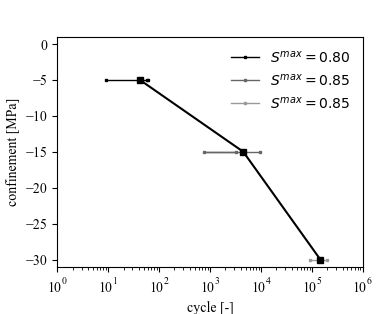

In [29]:
cm = 1/2.54  # centimeters in inches
plt.style.use('grayscale')

plt.tight_layout()
plt.rcParams["font.family"] = "Times New Roman"
N = np.array([42,4499,146794])

first_level_x = [9, 60, 57]
first_level_y = [-5, -5 ,-5]

second_level_x = [9454, 747, 3296]
second_level_y = [-15,-15,-15]

third_level_x = [92349, 201420]
third_level_y = [-30, -30]

compression_level = np.array([-5,-15,-30])
fig, (ax) = plt.subplots(1, 1,figsize=(9.7*cm, 8*cm))


ax.plot(first_level_x, first_level_y,  '-s', markersize=2, linewidth=1, label = '$S^{max} = 0.80$')  
ax.plot(second_level_x, second_level_y,  '-s', markersize=2,linewidth=1 , label = '$S^{max} = 0.85$')  
ax.plot(third_level_x, third_level_y,  '-s', markersize=2,linewidth=1, label = '$S^{max} = 0.85$')  
ax.plot(N, compression_level,  '-ks', markersize=4)  
ax.legend(frameon=False)

ax.set_xlim(10**0,10**6)
ax.set_ylim(-31,1)
ax.set_xscale('log')

ax.set_ylabel('confinement [MPa]')
ax.set_xlabel('cycle [-]')


left  = 0.15  # the left side of the subplots of the figure
right = 0.95  # the right side of the subplots of the figure
bottom = 0.15   # the bottom of the subplots of the figure
top = 1.0   # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)


fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\wohler_exp.pdf')
